## Imports and Setup

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model

In [2]:
# import gdown 

# url = 'https://drive.google.com/uc?id=1PWoGfal9b_rRBLk8TBcyboGAhWV-A5hD'
# output = 'dataset.zip'

# gdown.download(url, output, quiet=False)

In [3]:
# !unzip dataset.zip

## Create Dataset

In [4]:
data_dir = '../dataset/images'
BATCH_SIZE = 8
IMG_SIZE = (224, 224)

In [5]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  label_mode='categorical',
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 4815 files belonging to 137 classes.
Using 3852 files for training.


2021-10-03 06:46:25.329751: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/mesa-diverted/x86_64-linux-gnu:/usr/lib/x86_64-linux-gnu/mesa:/usr/lib/x86_64-linux-gnu/dri:/usr/lib/x86_64-linux-gnu/gallium-pipe:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2021-10-03 06:46:25.330620: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-10-03 06:46:25.330939: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural

In [6]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  label_mode='categorical',
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 4815 files belonging to 137 classes.
Using 963 files for validation.


In [7]:
class_names = train_dataset.class_names
# class_names

## Visualize some

In [8]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
# for images, labels in train_dataset.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

In [9]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8, 224, 224, 3)
(8, 137)


2021-10-03 06:46:25.725535: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [10]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [11]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 97
Number of test batches: 24


### Configuring dataset for Performance

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use Data Augmentation

In [13]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.4),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.4),
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


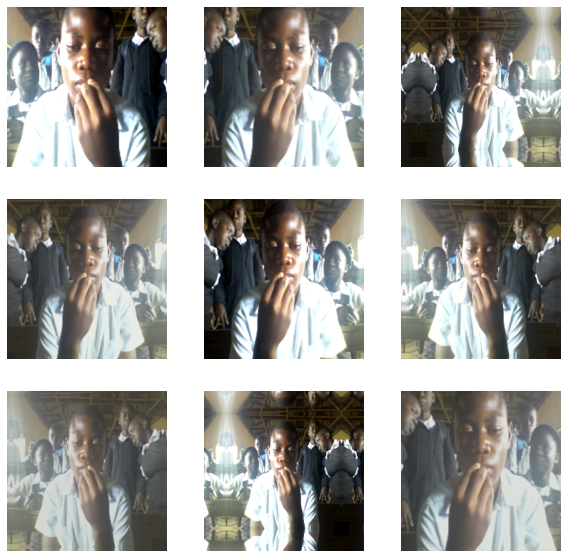

In [14]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In [15]:
# preprocess_input = tf.keras.applications.resnet_v2.preprocess_input
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [16]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

## Create the base model from the pre-trained convnets

In [17]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
# base_model = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet')

In [18]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(8, 7, 7, 1280)


## Feature Extraction

In [19]:
base_model.trainable = False

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(8, 1280)


In [21]:
prediction_layer = tf.keras.layers.Dense(137, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(8, 137)


In [22]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [23]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

/home/kolawolesteven99/venv/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [24]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [47]:
!pip install pydot

You should consider upgrading via the '/home/kolawolesteven99/venv/bin/python -m pip install --upgrade pip' command.


In [48]:
plot_model(model)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [25]:
len(model.trainable_variables)

2

In [26]:
initial_epochs = 60
loss0, accuracy0, precision0, recall0 = model.evaluate(validation_dataset)

97/97 [==============================] - 7s 59ms/step - loss: 5.3619 - accuracy: 0.0091 - precision: 0.0000e+00 - recall: 0.0000e+00


In [27]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/60
482/482 [==============================] - 40s 78ms/step - loss: 5.2257 - accuracy: 0.0135 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 4.8842 - val_accuracy: 0.0233 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/60
482/482 [==============================] - 38s 79ms/step - loss: 4.8651 - accuracy: 0.0262 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 4.7125 - val_accuracy: 0.0415 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/60
482/482 [==============================] - 38s 78ms/step - loss: 4.6889 - accuracy: 0.0402 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 4.5830 - val_accuracy: 0.0636 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/60
482/482 [==============================] - 38s 78ms/step - loss: 4.5033 - accuracy: 0.0576 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 4.4487 - val_accuracy: 0.0778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/60
482/482 [============

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

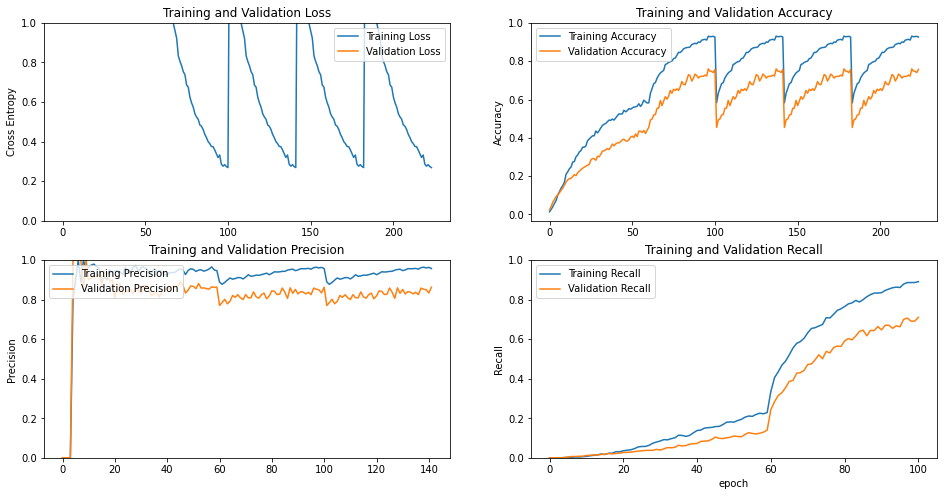

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

precision = history.history['precision']
val_precision = history.history['val_precision']

recall = history.history['recall']
val_recall = history.history['val_recall']


plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')

plt.subplot(2, 2, 2)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 3)
plt.plot(precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.legend(loc='upper left')
plt.ylabel('Precision')
plt.ylim([0,1.0])
plt.title('Training and Validation Precision')

plt.subplot(2, 2, 4)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='upper left')
plt.ylabel('Recall')
plt.ylim([0,1.0])
plt.title('Training and Validation Recall')
plt.xlabel('epoch')
plt.show()

In [30]:
base_model.trainable = True

In [31]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [32]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [33]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [34]:
len(model.trainable_variables)

56

In [41]:
fine_tune_epochs = 70
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 60/150
482/482 [==============================] - 57s 119ms/step - loss: 0.2456 - accuracy: 0.9369 - precision_1: 0.9631 - recall_1: 0.9003 - val_loss: 1.1481 - val_accuracy: 0.7588 - val_precision_1: 0.8481 - val_recall_1: 0.7095
Epoch 61/150
482/482 [==============================] - 59s 122ms/step - loss: 0.2600 - accuracy: 0.9283 - precision_1: 0.9601 - recall_1: 0.8941 - val_loss: 1.1558 - val_accuracy: 0.7601 - val_precision_1: 0.8488 - val_recall_1: 0.6991
Epoch 62/150
482/482 [==============================] - 58s 120ms/step - loss: 0.2489 - accuracy: 0.9299 - precision_1: 0.9649 - recall_1: 0.9001 - val_loss: 1.1906 - val_accuracy: 0.7510 - val_precision_1: 0.8229 - val_recall_1: 0.6991
Epoch 63/150
482/482 [==============================] - 59s 121ms/step - loss: 0.2255 - accuracy: 0.9426 - precision_1: 0.9651 - recall_1: 0.9125 - val_loss: 1.0982 - val_accuracy: 0.7782 - val_precision_1: 0.8610 - val_recall_1: 0.7393
Epoch 64/150
482/482 [==============================

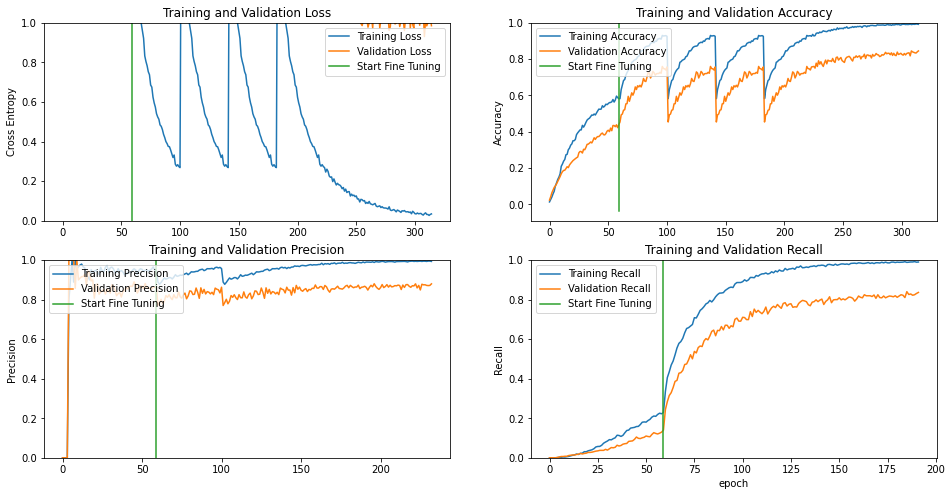

In [45]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

precision += history_fine.history['precision_1']
val_precision += history_fine.history['val_precision_1']

recall += history_fine.history['recall_1']
val_recall += history_fine.history['val_recall_1']


plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')

plt.subplot(2, 2, 2)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 3)
plt.plot(precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper left')
plt.ylabel('Precision')
plt.ylim([0,1.0])
plt.title('Training and Validation Precision')

plt.subplot(2, 2, 4)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper left')
plt.ylabel('Recall')
plt.ylim([0,1.0])
plt.title('Training and Validation Recall')
plt.xlabel('epoch')
plt.show()

In [46]:
model.evaluate(test_dataset)

24/24 [==============================] - 2s 60ms/step - loss: 0.5430 - accuracy: 0.9115 - precision_1: 0.9355 - recall_1: 0.9062


[0.5429883003234863, 0.9114583134651184, 0.9354838728904724, 0.90625]